<div style="text-align: center;">
    <h1>🔗 Binance API data pulling</h1>
</div>

Earliest available 1-minute data:
- BTCUSDT: 17-08-2017
- ETHUSDT: 06-07-2017

Empty data (Binance suspended trading):
No data found for 2018-02-08 00:29:00 to 2018-02-08 17:09:00.

Data havent pulled:
2018-02-08 17:10:00 to 2018-02-09 23:59:00.

seems some data between cant be pulled as well, incline to 2018-02-08 17:10:00

<div style="text-align: center;">
    <h1> BTCUSDT - 1hour - (10-02-2018 to 31-03-2025)</h1>
</div>

Fetching 1h data for BTCUSDT from 2018-02-10 00:00:00 to 2025-04-01 00:00:00...
Fetching data from 2018-02-10 00:00:00 to 2018-02-10 16:40:00...
Fetching data from 2018-02-10 08:01:00 to 2018-02-11 00:41:00...
Fetching data from 2018-02-11 00:01:00 to 2018-02-11 16:41:00...
Fetching data from 2018-02-11 16:01:00 to 2018-02-12 08:41:00...
Fetching data from 2018-02-12 08:01:00 to 2018-02-13 00:41:00...
Fetching data from 2018-02-13 00:01:00 to 2018-02-13 16:41:00...
Fetching data from 2018-02-13 16:01:00 to 2018-02-14 08:41:00...
Fetching data from 2018-02-14 08:01:00 to 2018-02-15 00:41:00...
Fetching data from 2018-02-15 00:01:00 to 2018-02-15 16:41:00...
Fetching data from 2018-02-15 16:01:00 to 2018-02-16 08:41:00...
Fetching data from 2018-02-16 08:01:00 to 2018-02-17 00:41:00...
Fetching data from 2018-02-17 00:01:00 to 2018-02-17 16:41:00...
Fetching data from 2018-02-17 16:01:00 to 2018-02-18 08:41:00...
Fetching data from 2018-02-18 08:01:00 to 2018-02-19 00:41:00...
Fetching d

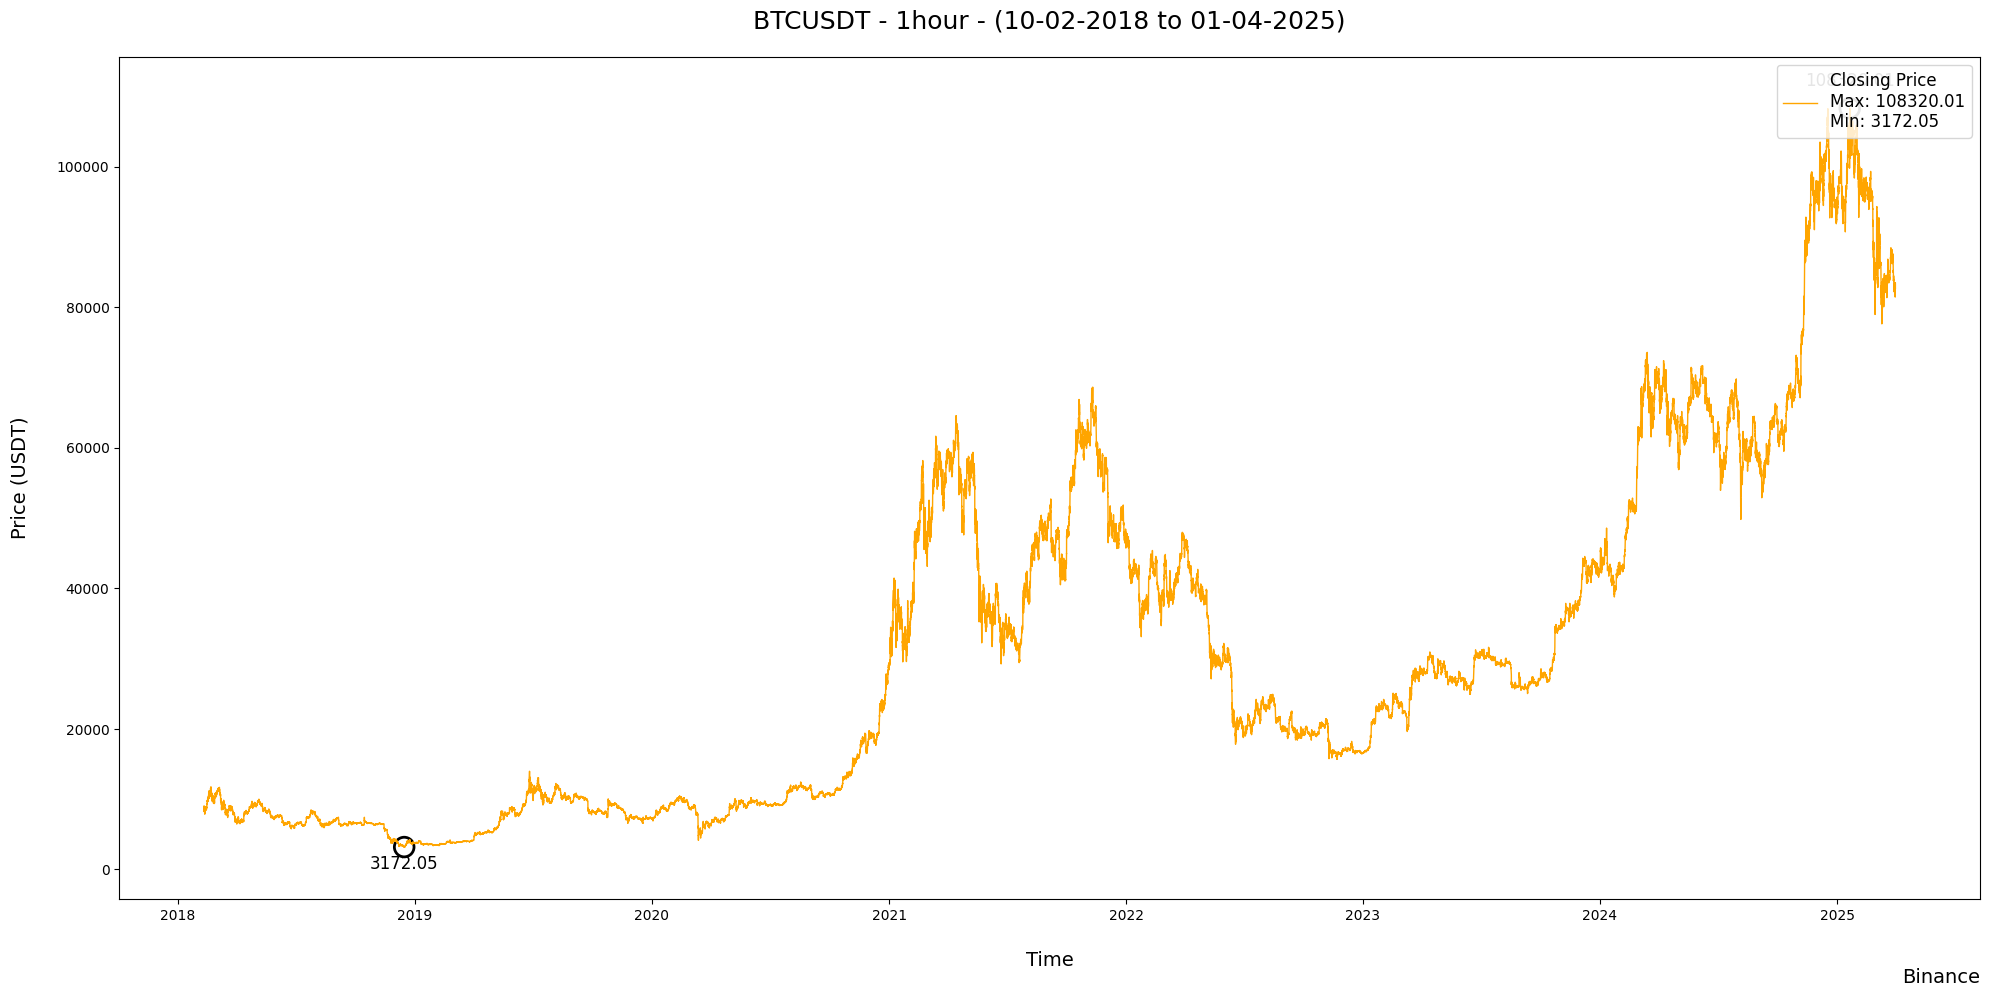

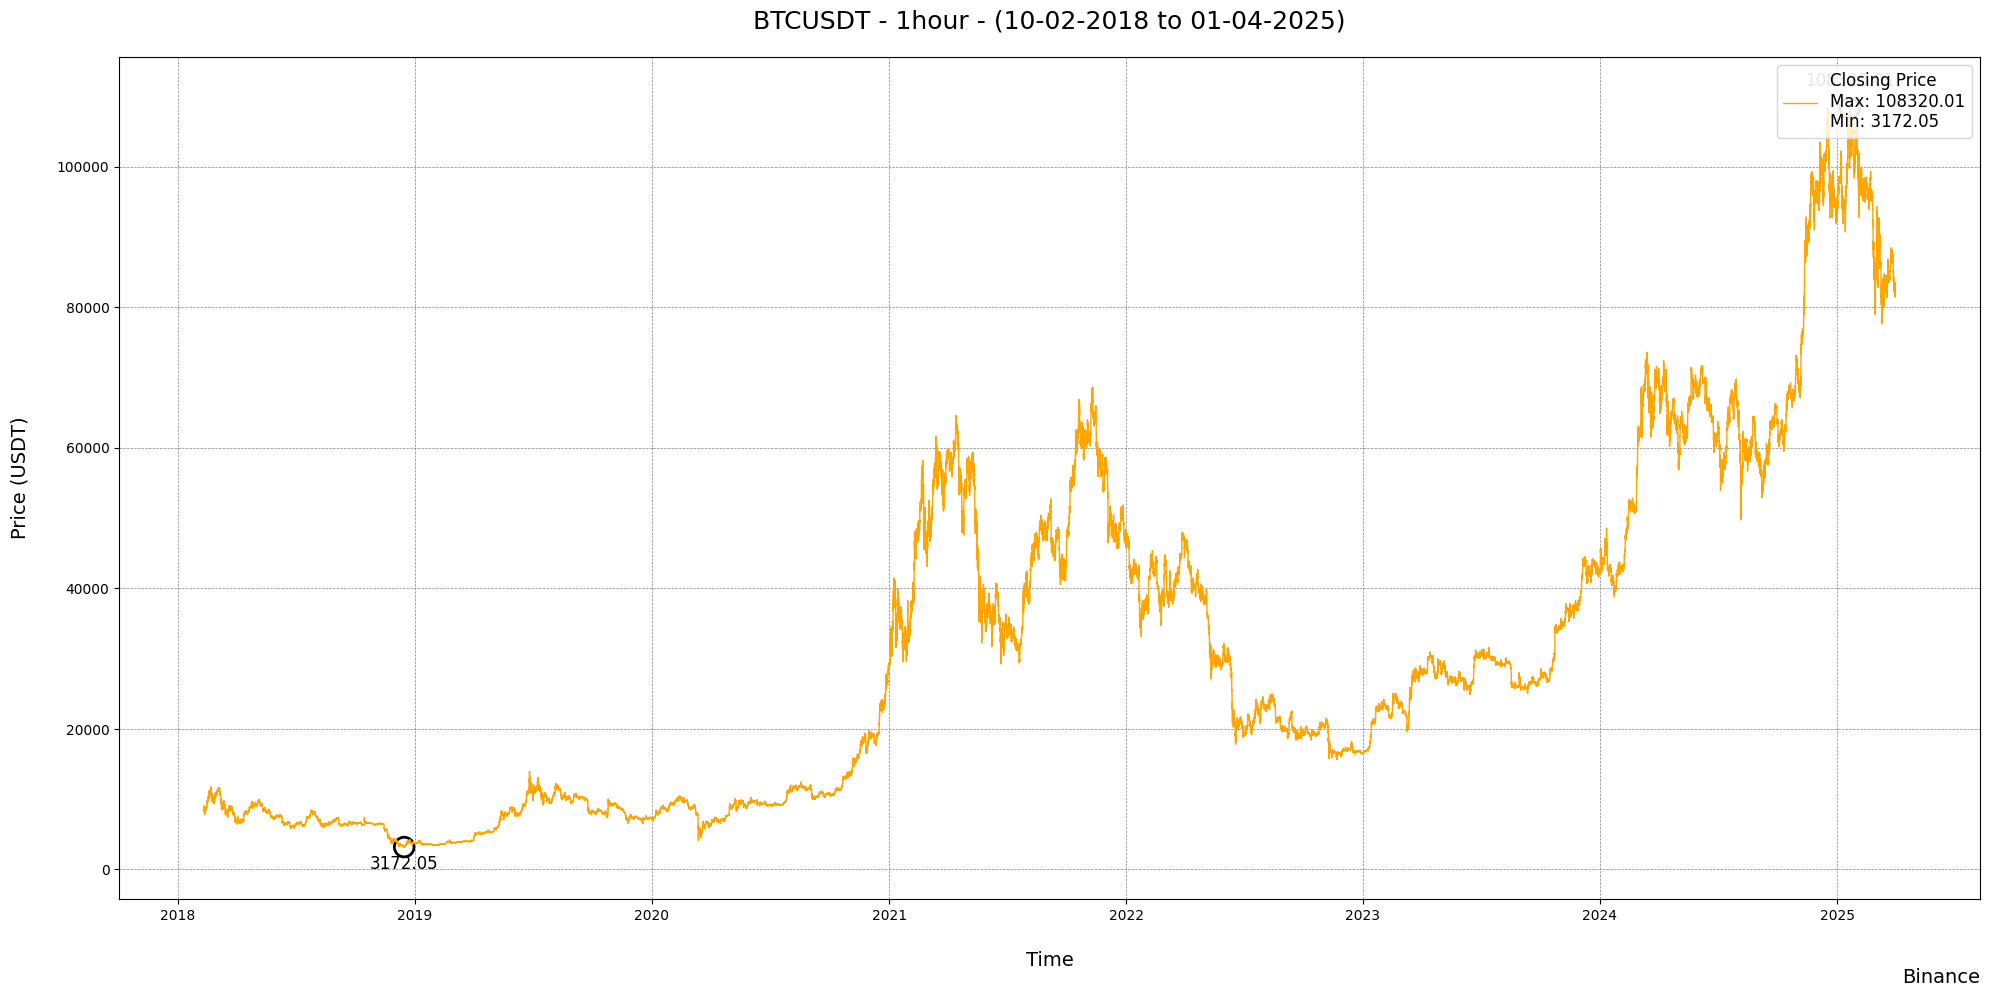

In [1]:
import pandas as pd
import datetime as dt
import requests
import time
import matplotlib.pyplot as plt


def get_binance_bars(symbol, interval, start_time, end_time):
    """
    Fetch candlestick (OHLCV) data from Binance API.

    Args:
        symbol (str): Trading pair, e.g., "BTCUSDT".
        interval (str): Time interval, e.g., "1m", "5m".
        start_time (datetime): Start time for data fetching.
        end_time (datetime): End time for data fetching.

    Returns:
        pd.DataFrame: Candlestick data with datetime index.
    """
    url = "https://api.binance.com/api/v3/klines"
    start_time = int(start_time.timestamp() * 1000)  # Convert to milliseconds
    end_time = int(end_time.timestamp() * 1000)  # Convert to milliseconds
    limit = 1000  # Binance API max limit per request

    params = {
        "symbol": symbol,
        "interval": interval,
        "startTime": start_time,
        "endTime": end_time,
        "limit": limit,
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"Error fetching data: {response.status_code}, {response.text}")

    data = response.json()
    if not data:
        return pd.DataFrame()  # Return empty DataFrame if no data

    # Convert the response into a DataFrame
    df = pd.DataFrame(data)
    df = df.iloc[:, 0:6]  # Select relevant columns
    df.columns = ["datetime", "open", "high", "low", "close", "volume"]
    df["datetime"] = pd.to_datetime(df["datetime"], unit="ms")  # Convert to readable datetime
    df.set_index("datetime", inplace=True)
    df[["open", "high", "low", "close", "volume"]] = df[
        ["open", "high", "low", "close", "volume"]
    ].astype(float)

    return df


def fetch_historical_data(symbol, interval, start_date, end_date):
    """
    Fetch historical data across the selected date range in chunks.

    Args:
        symbol (str): Trading pair, e.g., "BTCUSDT".
        interval (str): Time interval, e.g., "1m".
        start_date (datetime): Start date for data fetching.
        end_date (datetime): End date for data fetching.

    Returns:
        pd.DataFrame: Combined DataFrame containing all fetched data.
    """
    all_data = []
    chunk_start = start_date

    # Fetch data in 1000-minute chunks
    while chunk_start < end_date:
        chunk_end = chunk_start + dt.timedelta(minutes=1000)
        if chunk_end > end_date:
            chunk_end = end_date

        print(f"Fetching data from {chunk_start} to {chunk_end}...")
        df = get_binance_bars(symbol, interval, chunk_start, chunk_end)
        if df.empty:
            print(f"No data found for {chunk_start} to {chunk_end}.")
            break

        all_data.append(df)
        chunk_start = df.index[-1] + dt.timedelta(minutes=1)  # Avoid overlapping

        time.sleep(1)  # Respect API rate limits

    # Combine all chunks into a single DataFrame
    if all_data:
        combined_data = pd.concat(all_data)
        combined_data = combined_data.sort_index()  # Ensure data is sorted
        return combined_data
    else:
        print("No data fetched.")
        return pd.DataFrame()


def plot_data(data, symbol, interval, start_date, end_date, clean=False):
    """
    Plot the close price of the data and display the graph.

    Args:
        data (pd.DataFrame): The historical data to plot.
        symbol (str): Trading pair, e.g., "BTCUSDT".
        interval (str): Time interval, e.g., "1m", "5m".
        start_date (datetime): Start date of the data.
        end_date (datetime): End date of the data.
        clean (bool): If True, generate a clean graph without gridlines.
    """
    plt.figure(figsize=(20, 10))  # Larger graph for Jupyter Notebook

    # Calculate y-axis range with extra space for a smaller price line
    price_range = data["close"].max() - data["close"].min()
    y_min = data["close"].min() - 0.07 * price_range  # Increase to 7% extra space below
    y_max = data["close"].max() + 0.07 * price_range  # Increase to 7% extra space above

    # Plot the price line
    plt.plot(data.index, data["close"], label="Closing Price", color="orange", linewidth=1)  # Thinner orange line

    # Highlight max and min points
    max_price = data["close"].max()
    min_price = data["close"].min()
    max_time = data["close"].idxmax()
    min_time = data["close"].idxmin()

    # Use hollow circles for max and min points
    plt.scatter(max_time, max_price, edgecolor="grey", facecolor="none", s=200, linewidth=2)
    plt.text(max_time, max_price + 0.03 * price_range, f"{max_price:.2f}", color="grey", fontsize=12, ha="center")

    plt.scatter(min_time, min_price, edgecolor="black", facecolor="none", s=200, linewidth=2)
    plt.text(min_time, min_price - 0.03 * price_range, f"{min_price:.2f}", color="black", fontsize=12, ha="center")

    # Set y-axis limits
    plt.ylim(y_min, y_max)

    # Axis labels and title
    plt.xlabel("Time", fontsize=14, labelpad=20)  # Add space between axis and label
    plt.ylabel("Price (USDT)", fontsize=14, labelpad=20)  # Add space on y-axis
    plt.title(
        f"{symbol} - {interval} - ({start_date.strftime('%d-%m-%Y')} to {end_date.strftime('%d-%m-%Y')})",
        loc="center",
        fontsize=18,
        pad=20,  # Adjusted for better spacing
    )

    # Add max and min values below "Closing Price" in the legend area
    plt.legend(
        [
            f"Closing Price\nMax: {max_price:.2f}\nMin: {min_price:.2f}",
        ],
        loc="upper right",
        fontsize=12,
    )

    # Add "Binance" in the bottom-right corner
    plt.text(
        1.0,
        -0.1,
        "Binance",
        fontsize=14,
        horizontalalignment="right",
        transform=plt.gca().transAxes,
    )

    # Remove gridlines for clean graph
    if clean:
        plt.grid(False)
    else:
        plt.grid(color="grey", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # User inputs for symbol, interval, and date range

    # Common trading pairs: BTCUSDT, ETHUSDT, BNBUSDT, ADAUSDT, XRPUSDT
    symbol = input("Enter the trading pair (e.g., BTCUSDT, ETHUSDT): ").strip().upper()  # Convert to uppercase
    if not symbol:
        symbol = "BTCUSDT"  # Default trading pair

    # Common intervals: 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 1d, 1w, 1m (1 month), 1y (1 year)
    interval = input(
        "Enter the interval (e.g., 1m, 5m, 15m, 1h, 4h, 1d, 1w, 1m, 1y): "
    ).strip().lower()
    if not interval:
        interval = "1m"  # Default interval

    start_date_str = input("Enter the start date (YYYY-MM-DD): ").strip()
    end_date_str = input("Enter the end date (YYYY-MM-DD): ").strip()

    try:
        start_date = dt.datetime.strptime(start_date_str, "%Y-%m-%d")
        end_date = dt.datetime.strptime(end_date_str, "%Y-%m-%d") + dt.timedelta(days=1)  # Include full end date
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD.")
        exit()

    # Fetch data
    print(f"Fetching {interval} data for {symbol} from {start_date} to {end_date}...")
    data = fetch_historical_data(symbol, interval, start_date, end_date)

    # Save to CSV if data exists
    if not data.empty:
        # Format the output file name
        start_date_formatted = start_date.strftime("%d-%m-%Y")
        end_date_formatted = (end_date - dt.timedelta(days=1)).strftime("%d-%m-%Y")  # Adjust for inclusive end date
        interval_name = interval.replace("m", "min").replace("h", "hour")  # Beautify interval

        output_file = f"{symbol} - {interval_name} - ({start_date_formatted} to {end_date_formatted}).csv"
        data.to_csv(output_file, index=True)
        print(f"Data saved to {output_file}")

        # Plot the clean graph first
        plot_data(data, symbol, interval_name, start_date, end_date, clean=True)

        # Plot the graph with gridlines
        plot_data(data, symbol, interval_name, start_date, end_date, clean=False)

    else:
        print("No data fetched.")